# Warcraft Lore Analysis

This notebook analyzes Warcraft lore through web scraping and text analysis to identify thematic patterns in character narratives. We'll examine themes like duty, power, sacrifice, corruption, and freedom across major characters like Arthas, Illidan, and Thrall.

## 1. Import Required Libraries

In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from collections import Counter
import PyPDF2  # for novels

## 2. Configuration Setup

In [15]:
# Analysis configuration
KEYWORDS = ['duty', 'power', 'sacrifice', 'corruption', 'freedom']

# Wowpedia URLs targeting dialog/quotes sections
URLS = {
    'arthas': ['https://wowpedia.fandom.com/wiki/Arthas_Menethil'],
    'illidan': ['https://wowpedia.fandom.com/wiki/Illidan_Stormrage'],
    'thrall': ['https://wowpedia.fandom.com/wiki/Thrall']
}

NOVELS = ['arthas_rise.pdf', 'illidan.pdf', 'lord_clans.pdf']  # upload paths

# Set to False to skip PDF processing and only use web sources
USE_PDFS = False

## 3. Web Scraper Function

In [16]:
def scrape_page(url, char):
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'html.parser')
    texts = [p.text for p in soup.find_all('p') if any(kw.lower() in p.text.lower() for kw in KEYWORDS)]
    return [{'char': char, 'source': url, 'text': t, 'keywords': [kw for kw in KEYWORDS if kw.lower() in t.lower()]} for t in texts]

## 4. PDF Novel Parser Function

In [17]:
def extract_novel(pdf_path, char):
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        texts = []
        for page in reader.pages:
            text = page.extract_text()
            if any(kw.lower() in text.lower() for kw in KEYWORDS):
                texts.append({
                    'char': char, 
                    'source': pdf_path, 
                    'text': text[:500], 
                    'keywords': [kw for kw in KEYWORDS if kw.lower() in text.lower()]
                })
    return texts

## 4b. Context Extraction Function

In [18]:
def extract_context(text, keyword, window=50):
    """Extract context around keyword occurrences with a character window."""
    kw_pos = [m.start() for m in re.finditer(re.escape(keyword), text, re.IGNORECASE)]
    contexts = []
    for pos in kw_pos:
        start = max(0, pos - window)
        end = min(len(text), pos + window + len(keyword))
        contexts.append(text[start:end])
    return contexts

## 5. Data Collection and Scraping

In [19]:
data = []

# Scrape web pages
print("Scraping web pages...")
for char, urls in URLS.items():
    for url in urls:
        if url.startswith('http'):  # Only scrape actual URLs
            try:
                scraped = scrape_page(url, char)
                data.extend(scraped)
                print(f"  {char}: Found {len(scraped)} passages from {url}")
            except Exception as e:
                print(f"  Error scraping {url}: {e}")

# Parse novel PDFs (optional)
if USE_PDFS:
    print("\nParsing PDF novels...")
    novel_mappings = [
        ('arthas_rise.pdf', 'arthas'),
        ('illidan.pdf', 'illidan'), 
        ('lord_clans.pdf', 'thrall')
    ]
    
    for novel, char in novel_mappings:
        try:
            novel_data = extract_novel(novel, char)
            data.extend(novel_data)
            print(f"  {char}: Found {len(novel_data)} passages from {novel}")
        except FileNotFoundError:
            print(f"  Novel file {novel} not found. Skipping.")
else:
    print("\nSkipping PDF processing (USE_PDFS = False)")

# Extract context around keywords for each passage
for passage in data:
    context_passages = []
    for kw in KEYWORDS:
        context_passages.extend(extract_context(passage['text'], kw))
    passage['context'] = ' | '.join(set(context_passages))  # unique

print(f"\nCollected {len(data)} passages from all sources.")

Scraping web pages...
  arthas: Found 23 passages from https://wowpedia.fandom.com/wiki/Arthas_Menethil
  illidan: Found 34 passages from https://wowpedia.fandom.com/wiki/Illidan_Stormrage
  thrall: Found 42 passages from https://wowpedia.fandom.com/wiki/Thrall

Skipping PDF processing (USE_PDFS = False)

Collected 99 passages from all sources.


## 6. Keyword Analysis and Filtering

Exported 99 passages to warcraft_passages.csv


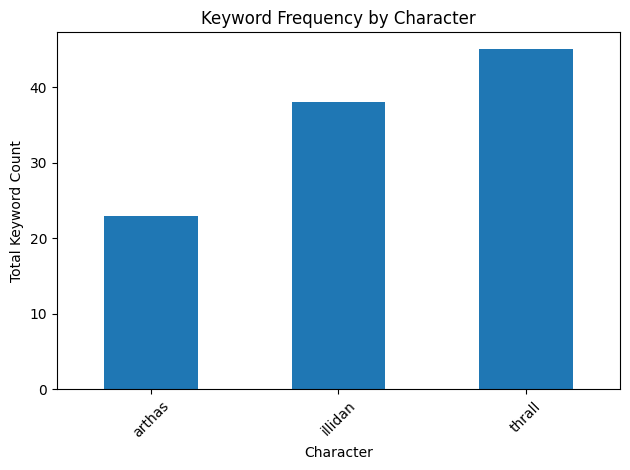


Keyword frequency by character:
char
arthas     23
illidan    38
thrall     45
Name: count, dtype: int64


In [20]:
import matplotlib.pyplot as plt

# Create DataFrame and analyze
df = pd.DataFrame(data)
if len(df) > 0:
    df['count'] = df['keywords'].apply(len)
    dense_passages = df[df['count'] >= 1].head(100)  # top dense
    
    # Export to CSV for Obsidian
    dense_passages.to_csv('warcraft_passages.csv', index=False)
    print(f"Exported {len(dense_passages)} passages to warcraft_passages.csv")
    
    # Create visualization
    char_counts = dense_passages.groupby('char')['count'].sum()
    char_counts.plot.bar(title='Keyword Frequency by Character')
    plt.ylabel('Total Keyword Count')
    plt.xlabel('Character')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nKeyword frequency by character:")
    print(char_counts)
else:
    print("No data collected. Check URLs and file paths.")

## 7. Text Clustering Analysis (Bonus)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

if len(dense_passages) > 0:
    # Vectorize text for clustering
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    X = vectorizer.fit_transform(dense_passages['text'])
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
    dense_passages['cluster'] = kmeans.labels_
    
    # Print sample passages from each cluster
    print("Sample passages by cluster:")
    for cluster_id in range(3):
        print(f"\n--- Cluster {cluster_id} ---")
        cluster_passages = dense_passages[dense_passages['cluster'] == cluster_id]
        if len(cluster_passages) > 0:
            sample = cluster_passages.iloc[0]
            print(f"Character: {sample['char']}")
            print(f"Keywords: {sample['keywords']}")
            print(f"Text: {sample['text'][:200]}...")
    
    # Export updated CSV with cluster information
    dense_passages.to_csv('warcraft_passages_clustered.csv', index=False)
    print(f"\nExported clustered data to warcraft_passages_clustered.csv")
else:
    print("No dense passages found for clustering analysis.")

Sample passages by cluster:

--- Cluster 0 ---
Character: illidan
Keywords: ['power']
Text: Illidan Stormrage, commonly known as the Betrayer, is the first of the demon hunters, the former self-proclaimed Lord of Outland, the former ruler of the Black Temple, and the original leader of the I...

--- Cluster 1 ---
Character: arthas
Keywords: ['duty']
Text: It is my sad duty to bring you very grim news. I am certain you know of Muradin's mission here in Northrend to strike at the Scourge and discover useful artifacts. We fought together against the Scour...

--- Cluster 2 ---
Character: arthas
Keywords: ['power']
Text: Despite his promising beginnings, Arthas became one of the most powerful and evil beings Azeroth would ever know. Although he killed the necromancer Kel'Thuzad, Arthas was unable to stop the spread of...

Exported clustered data to warcraft_passages_clustered.csv
